# Diabetes Prediction with Logistic Regression


Sınıflandırma problemi için bağımlı ve bağımsız değişkenler arasındaki ilişkiyi
doğrusal olarak modelleme



In [1]:
# Özellikleri belirtildiğinde kişilerin diyabet hastası olup olmadıklarını tahmin edebilecek bir makine öğrenmesi modeli

# Veri seti ABD'deki Ulusal Diyabet-Sindirim-Böbrek Hastalıkları Enstitüleri'nde tutulan büyük veri setinin
# parçasıdır. ABD'deki Arizona Eyaleti'nin en büyük 5. şehri olan Phoenix şehrinde yaşayan 21 yaş ve üzerinde olan
# Pima Indian kadınları üzerinde yapılan diyabet araştırması için kullanılan verilerdir. 768 gözlem ve 8 sayısal
# bağımsız değişkenden oluşmaktadır. Hedef değişken "outcome" olarak belirtilmiş olup; 1 diyabet test sonucunun
# pozitif oluşunu, 0 ise negatif oluşunu belirtmektedir.

# Değişkenler
# Pregnancies: Hamilelik sayısı
# Glucose: Glikoz.
# BloodPressure: Kan basıncı.
# SkinThickness: Cilt Kalınlığı
# Insulin: İnsülin.
# BMI: Beden kitle indeksi.
# DiabetesPedigreeFunction: Soyumuzdaki kişilere göre diyabet olma ihtimalimizi hesaplayan bir fonksiyon.
# Age: Yaş (yıl)
# Outcome: Kişinin diyabet olup olmadığı bilgisi. Hastalığa sahip (1) ya da değil (0)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
from sklearn.model_selection import train_test_split, cross_validate

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [3]:
# Exploratory Data Analysis

df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [4]:
# Target'ın Analizi

df["Outcome"].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

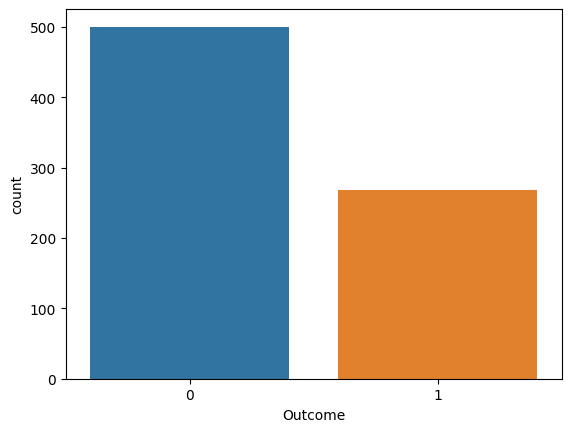

In [5]:
sns.countplot(x="Outcome", data=df)
plt.show()

In [6]:
100 * df["Outcome"].value_counts() / len(df)

Outcome
0   65.104
1   34.896
Name: count, dtype: float64

In [7]:
# Feature'ların Analizi

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


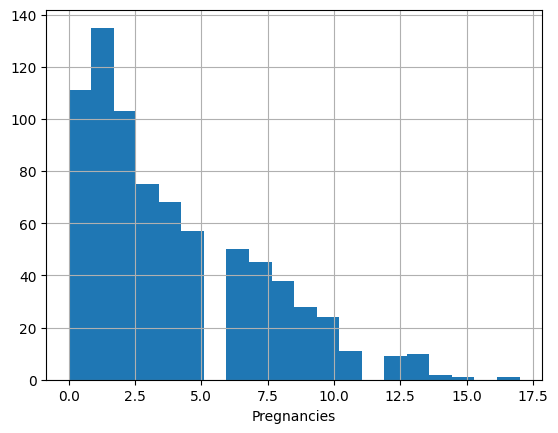

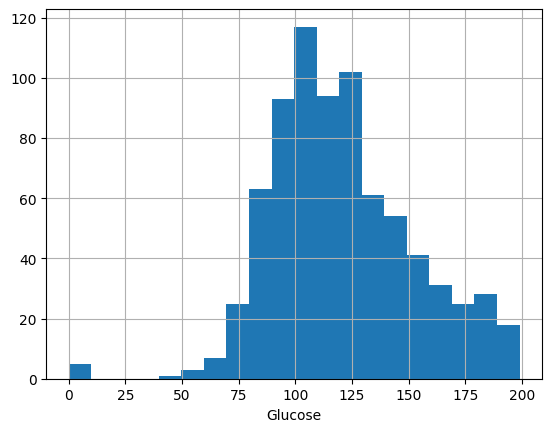

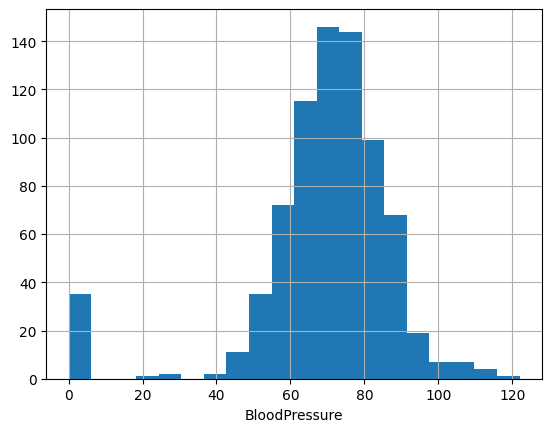

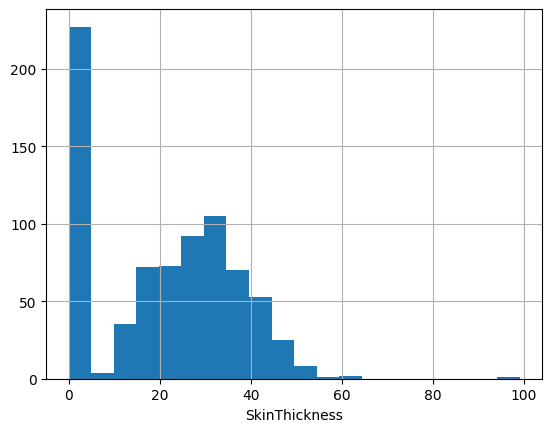

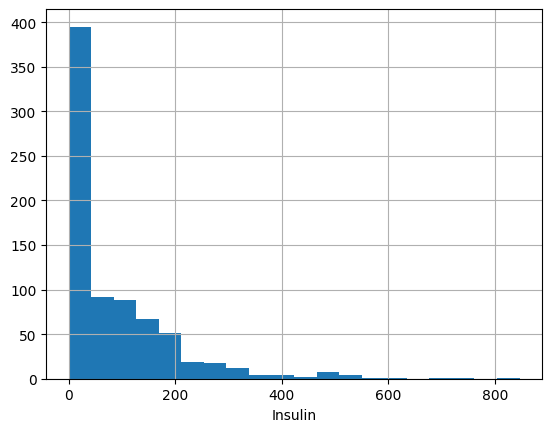

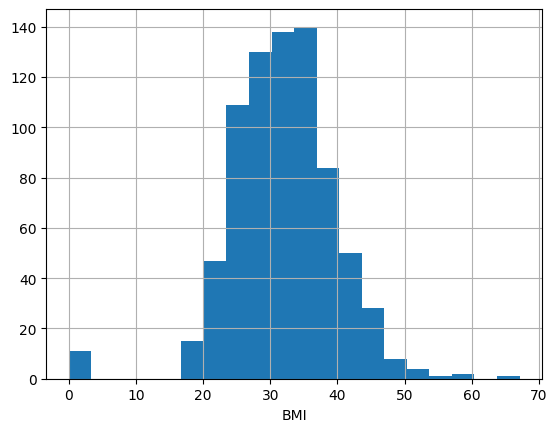

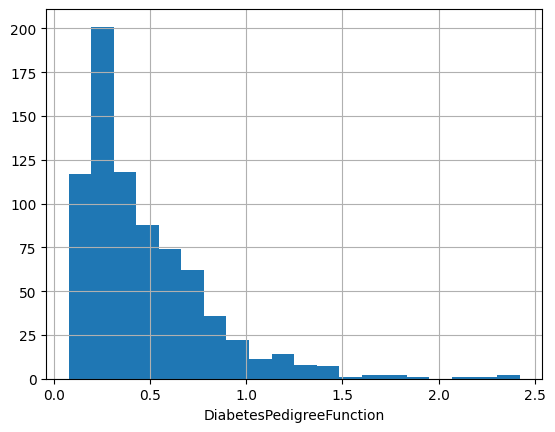

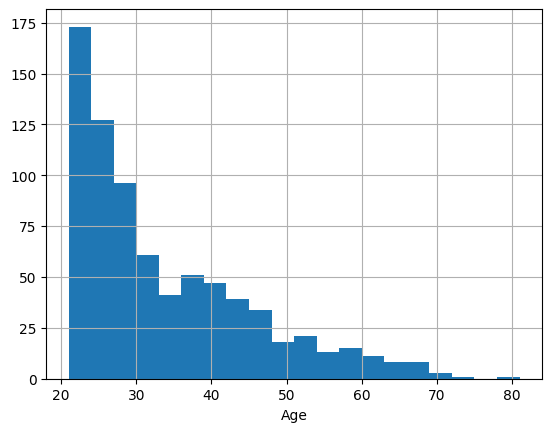

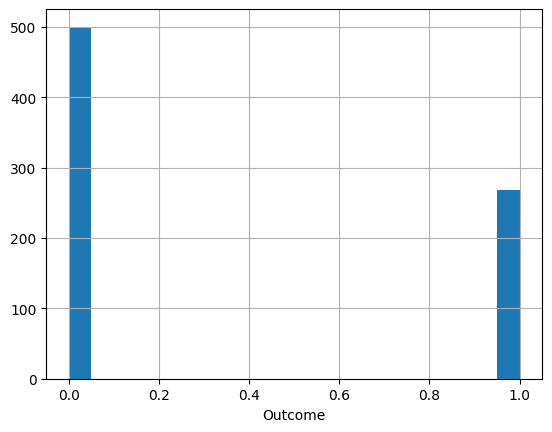

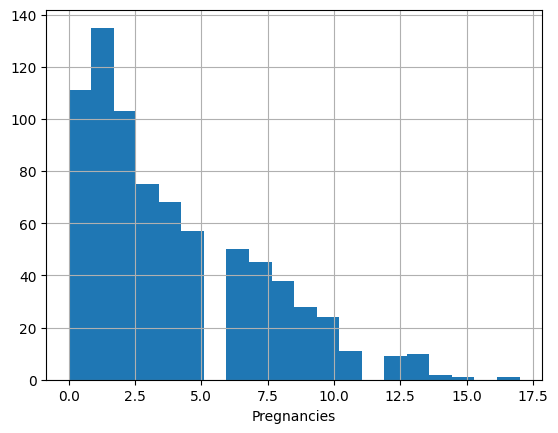

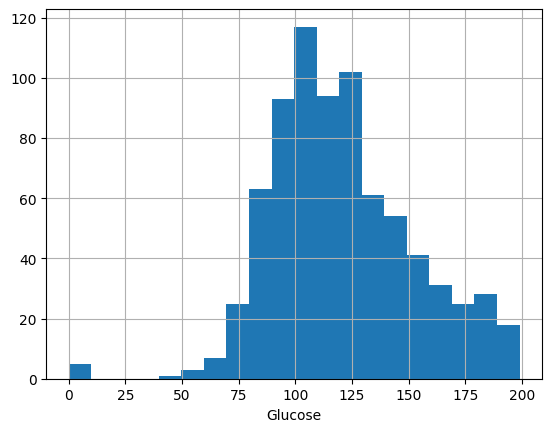

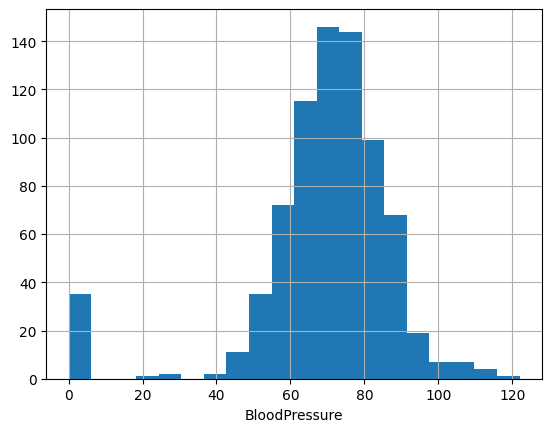

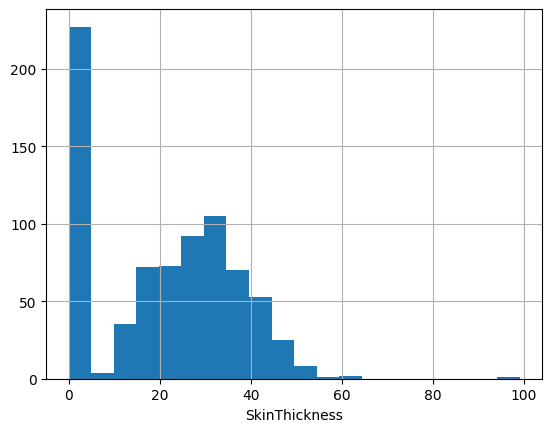

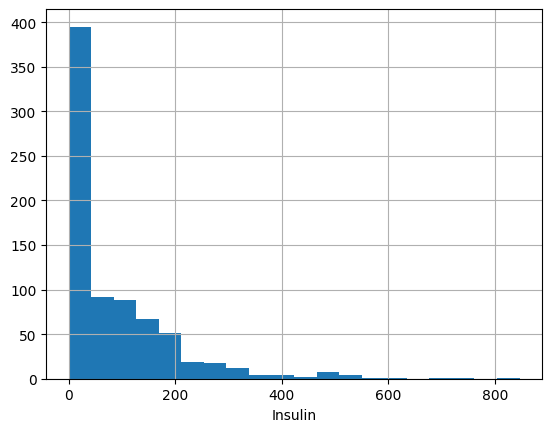

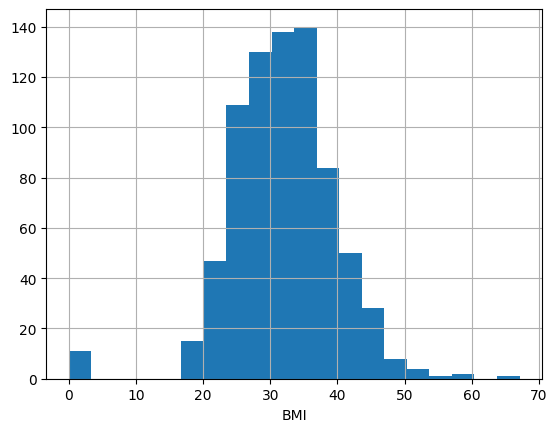

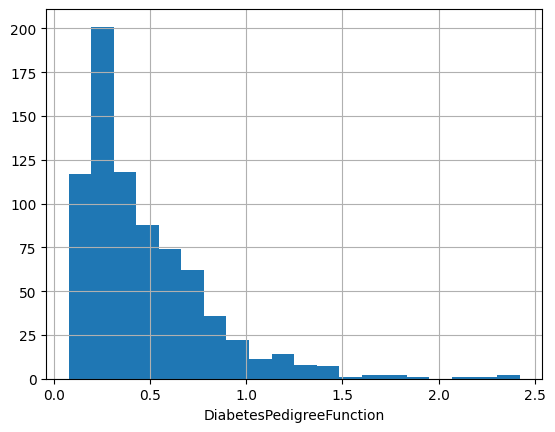

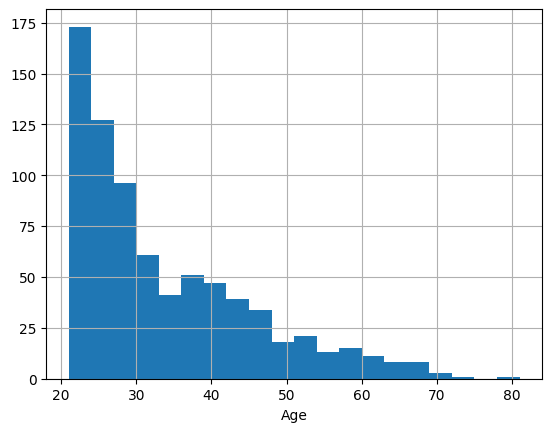

In [8]:
def plot_numerical_col(dataframe, numerical_col):
    dataframe[numerical_col].hist(bins=20)
    plt.xlabel(numerical_col)
    plt.show(block=True)


for col in df.columns:
    plot_numerical_col(df, col)

cols = [col for col in df.columns if "Outcome" not in col]

for col in cols:
    plot_numerical_col(df, col)

In [9]:
# Target vs Features

df.groupby("Outcome").agg({"Pregnancies": "mean"})

,Pregnancies
Outcome,
0,3.298
1,4.866


In [10]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




In [11]:
# Data Preprocessing (Veri Ön İşleme)

df.shape

(768, 9)

In [12]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [13]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [15]:
for col in cols:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False


In [16]:
replace_with_thresholds(df, "Insulin")

In [17]:
for col in cols:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


In [18]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0.000,33.600,0.627,50,1
1,1,85,66,29,0.000,26.600,0.351,31,0
2,8,183,64,0,0.000,23.300,0.672,32,1
3,1,89,66,23,94.000,28.100,0.167,21,0
4,0,137,40,35,168.000,43.100,2.288,33,1


In [19]:
df.shape

(768, 9)

(393, 9)

In [21]:
# Scaling
for col in cols:
    df[col] = RobustScaler().fit_transform(df[[col]])
    
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
3,-0.250,-0.682,-0.250,-0.375,-0.274,-0.586,-0.683,-0.462,0
4,-0.500,0.409,-1.875,0.375,0.381,1.138,4.403,0.462,1
6,0.250,-0.932,-1.250,0.188,-0.327,-0.253,-0.489,-0.077,1
8,0.000,1.773,0.000,1.000,3.699,-0.310,-0.705,2.000,1
13,-0.250,1.591,-0.625,-0.375,5.376,-0.356,-0.129,2.462,1


In [22]:
# Model & Prediction

y = df["Outcome"]

X = df.drop(["Outcome"], axis=1)

log_model = LogisticRegression().fit(X, y)

In [23]:
log_model.intercept_

array([-1.40508755])

In [24]:
log_model.coef_

array([[ 0.32094875,  1.58184989, -0.00680595,  0.18596266, -0.06210778,
         0.58602447,  0.45001507,  0.43561426]])

In [25]:
y_pred = log_model.predict(X)
y_pred[0:10]

array([0, 1, 0, 1, 1, 1, 0, 0, 0, 0], dtype=int64)

In [26]:
y[0:10]

3     0
4     1
6     1
8     1
13    1
14    1
16    1
18    0
19    1
20    0
Name: Outcome, dtype: int64

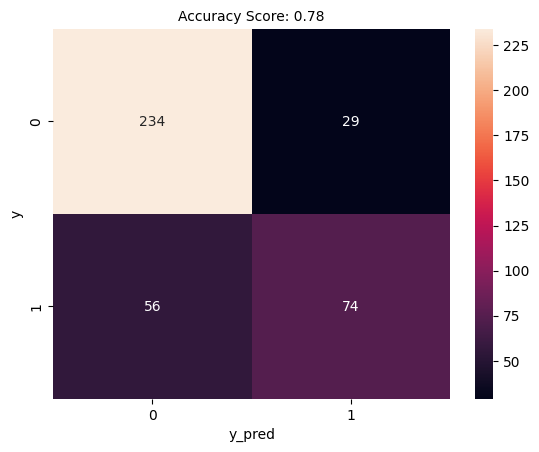

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       263
           1       0.72      0.57      0.64       130

    accuracy                           0.78       393
   macro avg       0.76      0.73      0.74       393
weighted avg       0.78      0.78      0.78       393



In [27]:
# Model Evaluation

def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y, y_pred)

print(classification_report(y, y_pred))


# Accuracy: 0.78
# Precision: 0.74
# Recall: 0.58
# F1-score: 0.65

In [28]:
# ROC AUC

y_prob = log_model.predict_proba(X)[:, 1]
roc_auc_score(y, y_prob)

0.8625621526762212

In [29]:
# Model Validation: Holdout

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20, random_state=17)

log_model = LogisticRegression().fit(X_train, y_train)
y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

# Accuracy: 0.77
# Precision: 0.79
# Recall: 0.53
# F1-score: 0.63

              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.77      0.59      0.67        29

    accuracy                           0.78        79
   macro avg       0.78      0.74      0.75        79
weighted avg       0.78      0.78      0.78        79



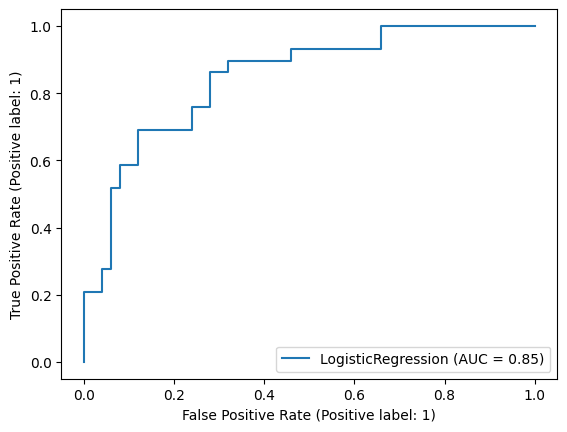

<Figure size 800x600 with 0 Axes>

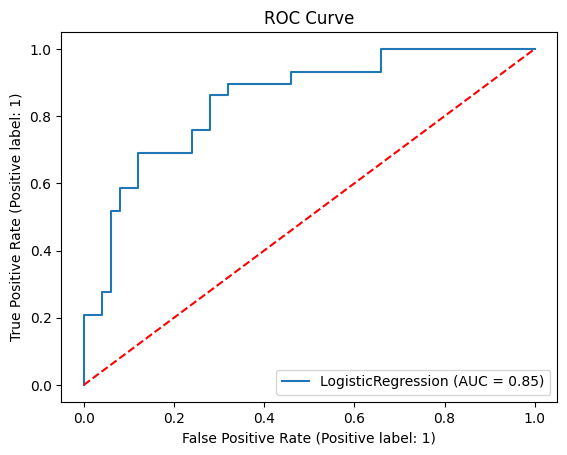

In [30]:
#RocCurveDisplay(log_model, X_test, y_test)

roc_display = RocCurveDisplay.from_estimator(log_model, X_test, y_test)

plt.figure(figsize=(8, 6))  # Optional: Set the figure size
roc_display.plot()

plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

In [31]:
# AUC
roc_auc_score(y_test, y_prob)

0.8468965517241379

In [32]:
# Model Validation: 5-Fold Cross Validation

y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

log_model = LogisticRegression().fit(X, y)

cv_results = cross_validate(log_model,
                            X, y,
                            cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

# Accuracy: 0.78
# Precision: 0.74
# Recall: 0.58
# F1-score: 0.65

# Accuracy: 0.77
# Precision: 0.79
# Recall: 0.53
# F1-score: 0.63

In [33]:
cv_results['test_accuracy']

array([0.83544304, 0.69620253, 0.74683544, 0.82051282, 0.82051282])

In [34]:
cv_results['test_accuracy'].mean()

0.7839013307367738

In [35]:
cv_results['test_precision'].mean()

0.7283982683982684

In [36]:
cv_results['test_recall'].mean()

0.5538461538461539

In [37]:
cv_results['test_f1'].mean()

0.6254779525131051

In [38]:
cv_results['test_roc_auc'].mean()

0.8471698113207546

In [39]:
# Prediction for A New Observation

X.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'], dtype='object')

In [40]:
random_user = X.sample(1, random_state=45)
random_user

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
318,0.250,-0.091,-0.250,0.625,0.133,0.563,-0.724,0.077


In [41]:
log_model.predict(random_user)

array([0], dtype=int64)